# Band Stacking, RGB & False Color Images Using Functions

## Objectives 
In this lesson, we will cover:
1. pulling in the function `aop_h5refl2array` to read in a reflectance hdf5 file and convert it a python 3-dimensional array (rows x columns x bands)
2. plotting different band combinations using the functions `plot_aop_refl` and `stack_rgb`, and 
3. using `widgets` for more interactive data visualization. 


## Background on RGB & False-Color Images

We can combine any three bands from the NEON reflectance data to make an **RGB** image that allows us to visualize spectral data collected at the Earth's surface. A **natural-color** image, made with bands from the red, green, and blue wavelengths looks close to what we would see with the naked eye, or what we would see in a typical photograph. We can also choose band combinations from other wavelengths, and map them to the red, blue, and green colors to highlight different spectral features. A **false-color** image is made with one or more bands from a non-visible portion of the electromagnetic spectrum that are mapped to red, green, and blue colors. These images can display other information about the landscape that is not easily seen with a natural-color image. 

The NASA Goddard Media Studio video *Peeling Back Landsat's Layers of Data* gives a good overview of natural and false color band combinations. Note that Landsat collects information from 11 wavelength bands, while NEON AOP hyperspectral data collects information from 426 bands!

<a href="https://www.youtube.com/watch?v=YP0et8l_bvY" target="_blank"><img src="./notebook_images//NASA_Goddard_RGB_Images.png" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>

https://www.youtube.com/watch?v=YP0et8l_bvY
https://svs.gsfc.nasa.gov//vis/a010000/a011400/a011491/index.html

**Further Reading**: Check out the NASA Earth Observatory Article on "How to Interpret a False-Color Satellite Image"

https://earthobservatory.nasa.gov/Features/FalseColor/

Before we get started, let's import our standard packages, and set up our plot preferences to inline so our figures show up in the notebook as we go:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py, os, osr, copy
%matplotlib inline

Use `pwd` (**p**rint **w**orking **d**irectory) to see what directory we're currently in.  

In [2]:
pwd

'/home/jovyan/work/CyverseNEON/hyperspectral'

Next we'll import some hyperspectral functions specific to the AOP data, from the `neon_aop_hyperspectral.py` module. We encourage you to look through the code in the module on your own time to gain a better understanding of how to read in the NEON hyperspectral hdf5 format. We'll start by reading in an h5 reflectance file using the `aop_h5refl2array` function, which pulls out the hyperspectral data cube (m x n x bands) and corresponding metadata that contains relevant information such as the spatial referencing. 

This function also cleans the reflectance data: it sets any no data values within the reflectance tile to `NaN` (not a number) and applies the reflectance scale factor so the final array that is returned represents unitless scaled reflectance, with values ranging between 0 and 1 (0-100%). 

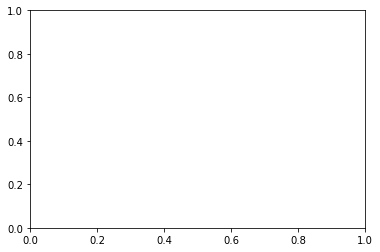

In [3]:
from neon_aop_hyperspectral import *

To see all the functions and modules we've imported use `%whos`

In [4]:
%whos

Variable           Type        Data/Info
----------------------------------------
aop_h5refl2array   function    <function aop_h5refl2array at 0x7f0318fa4550>
copy               module      <module 'copy' from '/opt<...>a/lib/python3.8/copy.py'>
exposure           module      <module 'skimage.exposure<...>ge/exposure/__init__.py'>
h5py               module      <module 'h5py' from '/opt<...>ckages/h5py/__init__.py'>
list_dataset       function    <function list_dataset at 0x7f0319fa8430>
ls_dataset         function    <function ls_dataset at 0x7f0319a6ba60>
np                 module      <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
os                 module      <module 'os' from '/opt/c<...>nda/lib/python3.8/os.py'>
osr                module      <module 'osr' from '/opt/<...>.8/site-packages/osr.py'>
plot_aop_refl      function    <function plot_aop_refl at 0x7f0310e97c10>
plot_aop_rgb       function    <function plot_aop_rgb at 0x7f0310e97d30>
plt                module   

As with standard python functions, we've included `docstrings` in these functions so that you can use `help` or `?` to display details about how to use the function. 

In [5]:
help(aop_h5refl2array)

Help on function aop_h5refl2array in module neon_aop_hyperspectral:

aop_h5refl2array(refl_filename)
    read in NEON AOP reflectance hdf5 file, convert to a cleaned reflectance 
    array and return associated metadata (spatial information and band center 
    wavelengths)
           
    Parameters
    ----------
        refl_filename : string
            reflectance hdf5 file name, including full or relative path
    
    Returns 
    --------
    reflArray : ndarray
        array of reflectance values
    metadata: dictionary 
        associated metadata containing
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)

Now that we have an idea of how this function works, let's try it out. First, set the variable `serc_h5_tile` to be reflectance data, specifying the relative path, or alterantively using `r'Path\To\File.h5'` or  `os.path.join` to create the full path to the data file. Note that if you want to run this notebook later on a different reflectance tile, you just have to change this variable. 

In [6]:
h5_tile = ('../../data/2019_JORN/Refl/NEON_D14_JORN_DP3_324000_3620000_reflectance.h5') 

Now that we've specified our reflectance tile, we can call `aop_h5refl2array` to read in the reflectance tile as a Python Numpy array called `refl` , and the associated metadata into a dictionary `metadata`.

In [7]:
refl,metadata = aop_h5refl2array(h5_tile)

We can use the `shape` method to see the dimensions of the array we read in. NEON tiles are (1000 x 1000 x # of bands), the number of bands may vary depending on the hyperspectral sensor used, but should be in the vicinity of 426.  

In [8]:
refl.shape

(1000, 1000, 426)

In [9]:
list(metadata.items())

[('map info',
  b'UTM,  1.000,  1.000,       324000.00,       3621000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0'),
 ('epsg', 32613),
 ('wavelength',
  array([ 381.5437,  386.5517,  391.5597,  396.5677,  401.5756,  406.5836,
          411.5916,  416.5996,  421.6075,  426.6155,  431.6235,  436.6314,
          441.6394,  446.6474,  451.6554,  456.6633,  461.6713,  466.6793,
          471.6872,  476.6952,  481.7032,  486.7112,  491.7191,  496.7271,
          501.7351,  506.7431,  511.751 ,  516.759 ,  521.767 ,  526.7749,
          531.7829,  536.7909,  541.7989,  546.8068,  551.8148,  556.8228,
          561.8307,  566.8387,  571.8467,  576.8547,  581.8626,  586.8706,
          591.8786,  596.8865,  601.8945,  606.9025,  611.9105,  616.9184,
          621.9264,  626.9344,  631.9424,  636.9503,  641.9583,  646.9663,
          651.9742,  656.9822,  661.9902,  666.9982,  672.0061,  677.0141,
          682.0221,  687.03  ,  692.038 ,  697.046 ,  702.054 ,  70

### Plot a single band of reflectance data 

Next we'll use the function `plot_aop_refl` to plot a single band of reflectance data. Read the `Parameters` section of the docstring to understand the required inputs & data type for each of these; only the band and spatial extent are required inputs, the rest are optional inputs that, if specified, allow you to set the range color values, specify the axis, add a title, colorbar, colorbar title, and change the colormap (default is to plot in greyscale). 

In [10]:
plot_aop_refl?

Signature:
plot_aop_refl(
    band_array,
    refl_extent,
    colorlimit=(0, 1),
    ax=<AxesSubplot:>,
    title='',
    cbar='on',
    cmap_title='',
    colormap='Greys',
)
Docstring:
read in and plot a single band or 3 stacked bands of a reflectance array
--------
Parameters
--------
    band_array: ndarray
        Array of reflectance values, created from aop_h5refl2array
        If 'band_array' is a 2-D array, plots intensity of values
        If 'band_array' is a 3-D array (3 bands), plots RGB image, set cbar to 'off' and don't need to specify colormap 
    refl_extent: tuple
        Extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
        Stored in metadata['spatial extent'] from aop_h5refl2array function
    colorlimit: tuple, optional
        Range of values to plot (min,max). 
        Look at the histogram of reflectance values before plotting to determine colorlimit.
    ax: axis handle, optional
        Axis to plot on; specify if making figure with subp

Now that we have loaded this function, let's extract a single band from the SERC reflectance array and plot it:

In [11]:
b56 = refl[:,:,55]

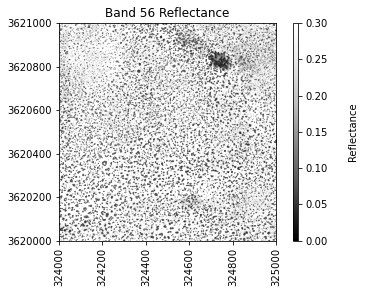

In [12]:
plot_aop_refl(b56,
              metadata['spatial extent'],
              colorlimit=(0,0.3),
              title='Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') 

## RGB Plots - Band Stacking
It is often useful to look at several bands together. We can extract and stack three reflectance bands in the red, green, and blue (RGB) spectrums to produce a color image that looks like what we see with our eyes; this is your typical camera image. In the next part of this tutorial, we will learn to stack multiple bands and make a geotif raster from the compilation of these bands. We can see that different combinations of bands allow for different visualizations of the remotely-sensed objects and also conveys useful information about the chemical makeup of the Earth's surface. 

For this exercise, we'll use the function `stack_rgb` to extract the bands we want to stack. This function uses splicing to extract the nth band from the reflectance array, and then uses the numpy function `stack` to create a new 3D array (1000 x 1000 x 3) consisting of only the three bands we want to visualize.

In [13]:
stack_rgb?

Signature: stack_rgb(reflArray, bands)
Docstring:
extract and stack three bands of a reflectance array 
--------
Parameters
--------
    reflArray: ndarray (m x n x #bands)
        Array of reflectance values, created from aop_h5refl2array
    bands: tuple
        Indices of bands to extract (R,G,B)

Returns 
--------
    stackedRGB: ndarray (m x n x 3)
        array containing 3 bands specified 
--------

Examples:
--------
>>> stack_rgb(sercRefl,(58,34,19)) 
File:      ~/work/CyverseNEON/hyperspectral/neon_aop_hyperspectral.py
Type:      function


First we will look at red, green, and blue bands, whos indices are defined below. To confirm that these band indices correspond to wavelengths in the expected portion of the spectrum, we can print out the wavelength values stored in `metadata['wavelength']`:

In [14]:
rgb_bands = (58,34,19)

print('Band 58 Center Wavelength = %.2f' %(metadata['wavelength'][57]),'nm')
print('Band 33 Center Wavelength = %.2f' %(metadata['wavelength'][33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(metadata['wavelength'][18]),'nm')

Band 58 Center Wavelength = 667.00 nm
Band 33 Center Wavelength = 546.81 nm
Band 19 Center Wavelength = 471.69 nm


We selected these bands so that they fall within the visible range of the electromagnetic spectrum (400-700 nm):

<img src="./notebook_images/NEON_AOP_RGB_Band_Wavelengths.png" style="width: 800px;">

Below we use `stack_rgb` to create an RGB array. Check that the dimensions of this array are as expected.
- **TIP**: checking the shape of arrays with the `.shape` method is a good habit to get into when creating your own workflows, and can be a handy tool for troubleshooting. 

In [15]:
rgb = stack_rgb(refl,rgb_bands)
rgb.shape

(1000, 1000, 3)

## Plot an RGB band combination

Next, we can use the function `plot_aop_refl`, even though we have more than one band. This function only works for a single or 3-band array, so ensure the array you use has the proper dimensions before using. You do not need to specify the colorlimits as the `matplotlib.pyplot` automatically scales 3-band arrays to 8-bit color (256). 

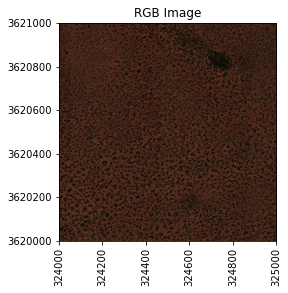

In [16]:
plot_aop_refl(rgb,
              metadata['spatial extent'],
              title='RGB Image',
              cbar='off') 

You'll notice that this image is very dark; it is possible to make out some of the features (roads, buildings), but it is not ideal. Since colorlimits don't apply to 3-band images, we have to use some other image processing tools to enhance the visibility of this image. 

## Image Processing -- Contrast Stretch & Histogram Equalization 

We can also try out some image processing routines to better visualize the reflectance data using the ```ski-image``` package. 

Histogram equalization is a method in image processing of contrast adjustment using the image's histogram. Stretching the histogram can improve the contrast of a displayed image by eliminating very high or low reflectance values that skew the display of the image. 

<p>
<img src="http://opencv-python-tutroals.readthedocs.io/en/latest/_images/histogram_equalization.png" style="width: 300px;"/>
</p>

Let's see what the image looks like using a 5% linear contrast stretch using the `skimage` module's `exposure` function.

In [17]:
plot_aop_rgb?

Signature: plot_aop_rgb(rgbArray, ext, ls_pct=5, plot_title='')
Docstring:
read in and plot 3 bands of a reflectance array as an RGB image
--------
Parameters
--------
    rgbArray: ndarray (m x n x 3)
        3-band array of reflectance values, created from stack_rgb
    ext: tuple
        Extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
        Stored in metadata['spatial extent'] from aop_h5refl2array function
    ls_pct: integer or float, optional
        linear stretch percent
    plot_title: string, optional
        image title

Returns 
--------
    plots RGB image of 3 bands of reflectance data
--------

Examples:
--------
>>> plot_aop_rgb(SERCrgb,
                 sercMetadata['spatial extent'],
                 plot_title = 'SERC RGB')
File:      ~/work/CyverseNEON/hyperspectral/neon_aop_hyperspectral.py
Type:      function


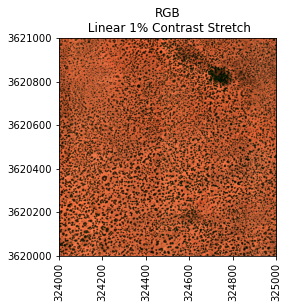

In [18]:
plot_aop_rgb(rgb,
             metadata['spatial extent'],
             ls_pct=1,
             plot_title = 'RGB')

## False Color Image - Color Infrared (CIR)
We can also create an image from bands outside of the visible spectrum. An image containing one or more bands outside of the visible range is called a **false-color image**. Here we'll use the green and blue bands as before, but we replace the red band with a near-infrared (NIR) band. 

For more information about non-visible wavelengths, false color images, and some frequently used false-color band combinations, refer to NASA's Earth Observatory page:

https://earthobservatory.nasa.gov/Features/FalseColor/

Band 90 Center Wavelength = 827.25 nm
Band 34 Center Wavelength = 546.81 nm
Band 19 Center Wavelength = 471.69 nm


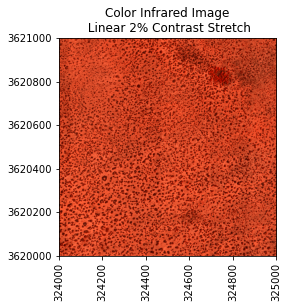

In [19]:
CIRbands = (90,34,19)
print('Band 90 Center Wavelength = %.2f' %(metadata['wavelength'][89]),'nm')
print('Band 34 Center Wavelength = %.2f' %(metadata['wavelength'][33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(metadata['wavelength'][18]),'nm')

cir = stack_rgb(refl,CIRbands)
plot_aop_rgb(cir,
             metadata['spatial extent'],
             ls_pct=2,
             plot_title='Color Infrared Image')

## Demo: Exploring Band Combinations Interactively

Now that we have made a couple different band combinations, we can demo a Python `widget` to explore different combinations of bands in the visible and non-visible portions of the spectrum. 

In [20]:
from ipywidgets import *

In [21]:
array = refl.copy()
metadata = metadata.copy()

In [22]:
def RGBplot_widget(R,G,B):
    
    #Pre-allocate array  size
    rgbArray = np.zeros((array.shape[0],array.shape[1],3), 'uint8')
    
    Rband = array[:,:,R-1].astype(float)
    #Rband_clean = clean_band(Rband,Refl_md)
    
    Gband = array[:,:,G-1].astype(float)
    #Gband_clean = clean_band(Gband,Refl_md)
    
    Bband = array[:,:,B-1].astype(float)
    #Bband_clean = clean_band(Bband,Refl_md)
    
    rgbArray[..., 0] = Rband*256
    rgbArray[..., 1] = Gband*256
    rgbArray[..., 2] = Bband*256
    
    # Apply Adaptive Histogram Equalization to Improve Contrast:
    
    img_nonan = np.ma.masked_invalid(rgbArray) #first mask the image 
    img_adapteq = exposure.equalize_adapthist(img_nonan, clip_limit=0.10)
    
    plot = plt.imshow(img_adapteq,extent=metadata['spatial extent']); 
    plt.title('Bands: \nR:' + str(R) + ' (' + str(round(metadata['wavelength'][R-1])) +'nm)'
              + '\n G:' + str(G) + ' (' + str(round(metadata['wavelength'][G-1])) + 'nm)'
              + '\n B:' + str(B) + ' (' + str(round(metadata['wavelength'][B-1])) + 'nm)'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 
    
interact(RGBplot_widget, R=(1,426,1), G=(1,426,1), B=(1,426,1));

interactive(children=(IntSlider(value=213, description='R', max=426, min=1), IntSlider(value=213, description=…

## Demo: Interactive Linear Stretch & Equalization

Here is another widget to play around with, demonstrating how to interactively visualize linear contrast stretches with a variable percent. 

In [23]:
rgbArray = rgb.copy()

In [24]:
def linearStretch(percent):
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=metadata['spatial extent'])
    plt.title('SERC RGB \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

interact(linearStretch,percent=(0,20,1));

interactive(children=(IntSlider(value=10, description='percent', max=20), Output()), _dom_classes=('widget-int…

### References & Resources

Kekesi, Alex et al. "NASA | Peeling Back Landsat's Layers of Data". https://svs.gsfc.nasa.gov/vis/a010000/a011400/a011491/. Published on Feb 24, 2014.

Riebeek, Holli. "Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image" https://earthobservatory.nasa.gov/Features/FalseColor/ 

Histogram Equalization: 
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

`skikit-image` tutorial:
http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py
